In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
data_path = Path('/../train/')

In [7]:
# config
# resnet34, efficientnet-b1, resnext101_32x8d_wsl, resnext101_32x16d_wsl
config = {
    "data_path": "../",
    "model": {
        "encoder_name": "efficientnet-b1",
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.003, "weight_decay": 0.0},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 500, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.3162,
                    "mode": "min",
                    "patience": 4,
                    "verbose": True,
                },
            },
        },
        "seg_model": "FPN",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 50,
    "seed": 42,
    "train_bs": 128,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 30,
        "min_epochs": 20,
        "accelerator": "mps",
        "devices": 1,
    },
    "valid_bs": 128,
    "workers": 0,
    "device": "mps",
    "folds": {
        "n_splits": 4,
        "random_state": 42,
        "train_folds": [0, 1, 2, 3]
    }
}


In [8]:
import torch
import numpy as np
import torchvision.transforms as T

class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True):

        self.df = df
        self.trn = train
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        con = np.load(str(con_path))

        img = con[..., :-1]
        label = con[..., -1]

        label = torch.tensor(label)

        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

        if self.image_size != 256:
            img = self.resize_image(img)

        img = self.normalize_image(img)

        return img.float(), label.float()

    def __len__(self):
        return len(self.df)

In [9]:
# Lightning module

import torch
import lightning.pytorch as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from lightning.pytorch.callbacks import ProgressBar
from torchmetrics.functional import dice, f1_score, jaccard_index
# from torchmetrics import IoU

bar = ProgressBar()

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)

        # flatten label and prediction tensors
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        return 1 - (2.0 * intersection + self.smooth) / (
            logits.sum() + targets.sum() + self.smooth
        )


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        ).to(self.device)
        self.loss_module = DiceLoss(smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch.to(self.device)
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        # val_dice = dice(all_preds, all_labels.long())
        # val_f1 = f1_score(all_preds.sigmoid(), all_labels.long(), task = "binary")
        val_iou = jaccard_index(num_classes=2, task='binary', preds=all_preds.sigmoid(), target=all_labels.long())
        self.log("val_iou", val_iou, on_step=False, on_epoch=True, prog_bar=True)

In [10]:
import warnings

warnings.filterwarnings("ignore")

import os
import torch
import pandas as pd
import lightning.pytorch as pl
from pprint import pprint
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader

contrails = os.path.join(config["data_path"], "contrails/")
train_path = os.path.join(config["data_path"], "train_df.csv")
valid_path = os.path.join(config["data_path"], "valid_df.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

train_df["path"] = contrails + train_df["record_id"].astype(str) + ".npy"
valid_df["path"] = contrails + valid_df["record_id"].astype(str) + ".npy"

dataset_train = ContrailsDataset(train_df, train=True)
dataset_validation = ContrailsDataset(valid_df, train=False)

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=True, num_workers=config["workers"]
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=False, num_workers=config["workers"]
)

pl.seed_everything(config["seed"])

filename = f"{config['model']['seg_model']}_{config['model']['encoder_name']}"

checkpoint_callback = ModelCheckpoint(
    monitor="val_iou",
    dirpath=config["output_dir"],
    mode="max",
    filename=filename,
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(refresh_rate=config["progress_bar_refresh_rate"])

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger=None, **config["trainer"]
)

model = LightningModule(config["model"])

trainer.fit(model, data_loader_train, data_loader_validation)

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name        | Type     | Params
-----------------------------------------
0 | model       | FPN      | 8.3 M 
1 | loss_module | DiceLoss | 0     
-----------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.060    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.641
Epoch 0, global step 161: 'val_iou' reached 0.22780 (best 0.22780), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.568
Epoch 1, global step 322: 'val_iou' reached 0.28376 (best 0.28376), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.546
Epoch 2, global step 483: 'val_iou' reached 0.30223 (best 0.30223), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.543
Epoch 3, global step 644: 'val_iou' reached 0.30491 (best 0.30491), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.542
Epoch 4, global step 805: 'val_iou' reached 0.30569 (best 0.30569), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 966: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.539
Epoch 6, global step 1127: 'val_iou' reached 0.30902 (best 0.30902), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.505
Epoch 7, global step 1288: 'val_iou' reached 0.33824 (best 0.33824), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.479
Epoch 8, global step 1449: 'val_iou' reached 0.36000 (best 0.36000), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.474
Epoch 9, global step 1610: 'val_iou' reached 0.36412 (best 0.36412), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1771: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1932: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2093: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2254: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.466
Epoch 14, global step 2415: 'val_iou' reached 0.37071 (best 0.37071), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.462
Epoch 15, global step 2576: 'val_iou' reached 0.37476 (best 0.37476), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 2737: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 2898: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 3059: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 3220: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.459
Epoch 20, global step 3381: 'val_iou' reached 0.37805 (best 0.37805), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.453
Epoch 21, global step 3542: 'val_iou' reached 0.38358 (best 0.38358), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/contrails/notebooks/models/FPN_efficientnet-b1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 3703: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 3864: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 4025: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 4186: 'val_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.453. Signaling Trainer to stop.
Epoch 26, global step 4347: 'val_iou' was not in top 1


In [11]:
# save the model
torch.save(model.state_dict(), f'models/{filename}.pt')

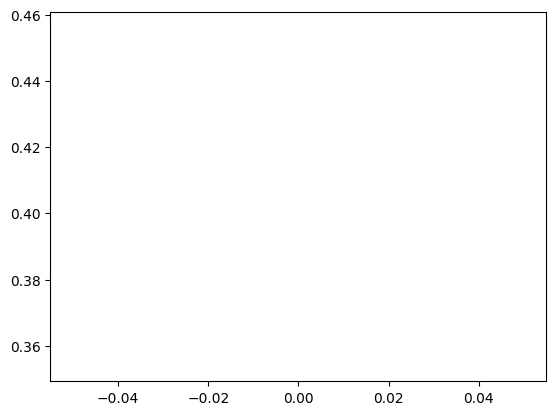

In [12]:
# plot the training and validation loss
plt.plot(trainer.callback_metrics['train_loss'])
plt.plot(trainer.callback_metrics['val_loss'])